# 第六章 其他分类方法

这一章介绍了不通过设计判别函数进行分类的分类方法。

### 一、k-近邻法

k-近邻法的思想非常简单，就是找到和待分类数据**最近的**（或者**最相似的**）$k$个已知样本。在这$k$个样本中，哪个类别最多，就把待分类的数据分类到这个最多的类别。

这里的**最近的**或者**最相似的**是通过设定函数来计算远近或者相似程度的。比如如果设定欧氏距离为距离函数，那么最近的样本就是欧氏距离最小的样本。

可以证明当样本趋于无穷时，k-近邻法的错误率在贝叶斯错误率的一倍到两倍之间。而且当$k$也趋于无穷并且是样本数的低阶无穷小时，k-近邻法的错误率逼近于贝叶斯错误率。

最简单的k-近邻法当然是对每个样本都进行比较，找出最近的$k$个样本。但是这样在样本数量巨大的时候运算非常慢，书上介绍了两种快速算法。

#### 1. 树搜索算法

书上介绍的树搜索算法采用了分治的思想，通过逐层搜索减少查询次数。书上给的例子是三叉树，并且每个子树是通过聚类来划分的。

但是实际应用中都会使用二叉树，也叫KD-tree。而且划分方式也不是聚类，而是通过方差来进行划分，具体算法书上没有介绍，我也就不说了。

另外KD-tree在高维样本下会失效，效率很低（20维以内效率很高）。高维的情况一般用ball-tree搜索最近样本，效率最高。在sklearn中有写好的库可以用KD-tree或ball-tree进行索引查询。

书上的树搜索算法第一不是主流算法，第二需要用到还没学的聚类，这里也就不实现了。

#### 2. 剪辑近邻法

剪辑近邻法的思想是：把样本分为训练集和测试集（书上叫考试集），用训练集的样本对测试集进行k-近邻划分，删除掉测试集中分错的部分。

这样一来可以使不同类别的分界面更为清晰，最终使错误率收敛于贝叶斯错误率。

具体实现算法使用MULTIEDIT算法，步骤如下：

1. 将样本随机划分成$s$个子集
2. 用第$i+1$个样本对第$i$个样本进行k-近邻分类，并删除掉分错的样本。
3. 把剩下的样本再混合，变成新的样本集，再回到第一步。
4. 如果经过了若干次迭代之后，每次迭代都没有样本别删掉，就判断为收敛，剪辑完成。

实现如下：

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

下面生成数据，这里人为的生成了线性不可分的数据（两类中间有重叠），这样来验证最终剪辑的效果

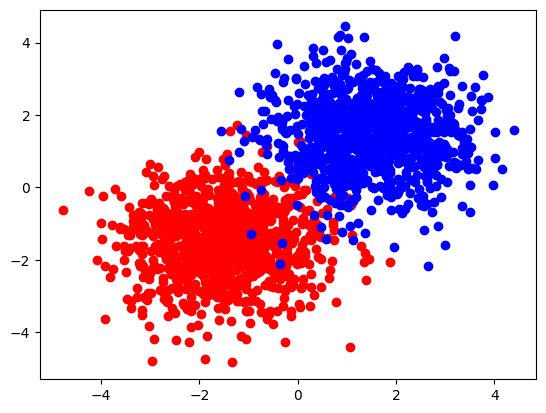

In [50]:
X = np.r_[np.random.randn(1000, 2) - [1.5, 1.5], np.random.randn(1000, 2) + [1.5, 1.5]]
y = 1000 * [1] + 1000 * [-1]

for i in range(2000):
    if y[i] == -1:
        plt.scatter(X[i][0], X[i][1], c='b')
    else:
        plt.scatter(X[i][0], X[i][1], c='r')

plt.show()

因为数据量比较大，图像需要运行一会才会显示出来。

通过上面的散点图可以明显看出两类数据有重叠，是线性不可分的。这样的数据很适合用剪辑法。

下面实现剪辑法的代码：

In [51]:
iters_without_edit = 0  # 存储最近有多少次迭代没有样本被剪掉，用于判断是否收敛
iters = 0               # 存储总的迭代轮数

while iters_without_edit < 5:

    # 将样本分为十个子类
    N = X.shape[0]  # N为当前一轮的样本总数（经过裁剪）
    X_split = []    # X_split是随机分割后的样本列表
    y_split = []    # y_split是随即分割后的真实类别列表
    indexes = np.random.permutation(N)
    for i in range(9):
        X_split.append(pd.DataFrame(X).iloc[indexes[N // 10 * i:N // 10 * (i + 1)]].to_numpy())
        y_split.append(pd.DataFrame(y).iloc[indexes[N // 10 * i:N // 10 * (i + 1)]].to_numpy())
    X_split.append(pd.DataFrame(X).iloc[indexes[N // 10 * 9:]].to_numpy())  # 最后一组单独处理，防止漏掉不能被10整除的部分
    y_split.append(pd.DataFrame(y).iloc[indexes[N // 10 * 9:]].to_numpy())

    # 开始剪辑
    knn = KNN(n_neighbors=10)

    deleted_samples = 0  # 用于记录一轮迭代剪掉了几个样本

    for i in range(10):
        j = i + 1 if i + 1 < 10 else 0
        knn.fit(X_split[j], y_split[j].reshape(y_split[j].shape[0]))
        y_predict = knn.predict(X_split[i])
        correct = []  # correct用于记录当前子集分类正确的序号
        for m in range(y_predict.shape[0]):
            if y_predict[m] == y_split[i][m]:
                correct.append(m)
            else:
                deleted_samples += 1
        X_split[i] = pd.DataFrame(X_split[i]).iloc[correct].to_numpy()
        y_split[i] = pd.DataFrame(y_split[i]).iloc[correct].to_numpy()


    X = X_split[0]
    y = y_split[0]
    for i in range(1, len(X_split)):
        X = np.concatenate((X, X_split[i]))
        y = np.concatenate((y, y_split[i]))

    if deleted_samples == 0:
        iters_without_edit += 1
    else:
        iters_without_edit = 0

    iters += 1
    print("第", iters, "次迭代，删除了", deleted_samples, "个样本")

print("迭代完成，次数：", iters)

第 1 次迭代，删除了 43 个样本
第 2 次迭代，删除了 11 个样本
第 3 次迭代，删除了 2 个样本
第 4 次迭代，删除了 2 个样本
第 5 次迭代，删除了 2 个样本
第 6 次迭代，删除了 3 个样本
第 7 次迭代，删除了 0 个样本
第 8 次迭代，删除了 4 个样本
第 9 次迭代，删除了 1 个样本
第 10 次迭代，删除了 0 个样本
第 11 次迭代，删除了 0 个样本
第 12 次迭代，删除了 0 个样本
第 13 次迭代，删除了 0 个样本
第 14 次迭代，删除了 0 个样本
迭代完成，次数： 14


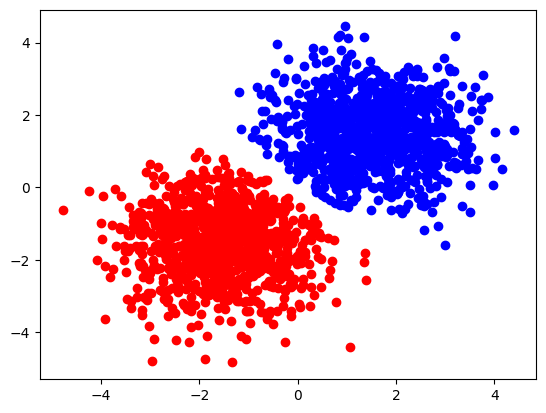

In [52]:
plt.clf()

for i in range(X.shape[0]):
    if y[i] == -1:
        plt.scatter(X[i][0], X[i][1], c='b')
    else:
        plt.scatter(X[i][0], X[i][1], c='r')

plt.show()

上面的图像也要等一会才能显示出来。

根据剪辑后的图像可以明显看出，两类样本的界限变得非常清晰，这就是剪辑的作用。

#### 3. 压缩近邻法

压缩近邻法可以大大减少训练样本数目，从而大幅提高分类速度。

具体算法是：

1. 将样本集分为**储存集**和**备选集**，储存集初始化为只有一个样本（我的理解是每个类都有一个样本，不然无法分类），其他都在备选集中。
2. 遍历每一个备选集的样本，用储存集对这个样本进行k-近邻分类，如果分类错误就把这个样本移动到储存集中。
3. 以此类推，直到没有样本需要移动。

压缩近邻法和剪辑近邻法一起使用会取得很好的效果，所以下面的数据用的是上面剪辑近邻处理过的。需要先跑一遍上面的代码再运行下面的。

算法实现如下：

In [63]:
X_s = np.concatenate(([X[0]], [X[-1]]))  # 储存集
y_s = np.concatenate(([y[0]], [y[-1]]))
X_g = X[1:-1]  # 备选集
y_g = y[1:-1]

is_all_samples_of_X_g_done = False  # 判断是否没有样本需要移动了

knn = KNN(n_neighbors=1)

while is_all_samples_of_X_g_done:
    iter_order = np.random.permutation(X_g.shape[0])
    is_all_samples_of_X_g_done = True
    for i in iter_order:
        knn.fit(X_s, y_s.reshape(y_s.shape[0]))
        if knn.predict(X_g[i]) != y_g[i]:
            X_s = np.concatenate((X_s, [X_g[i]]))
            y_s = np.concatenate((y_s, [y_g[i]]))
            if i == X_g.shape[0] - 1:
                X_g = X_g[:-1]
                y_g = y_g[:-1]
            elif i == 0:
                X_g = X_g[1:]
                y_g = y_g[1:]
            else:
                X_g = np.concatenate((X_g[:i], X_g[i + 1:]))
                y_g = np.concatenate((y_g[:i], y_g[i + 1:]))
            is_all_samples_of_X_g_done = False
            break

print("压缩完成，还剩", X_s.shape[0], "个样本")

压缩完成，还剩 2 个样本


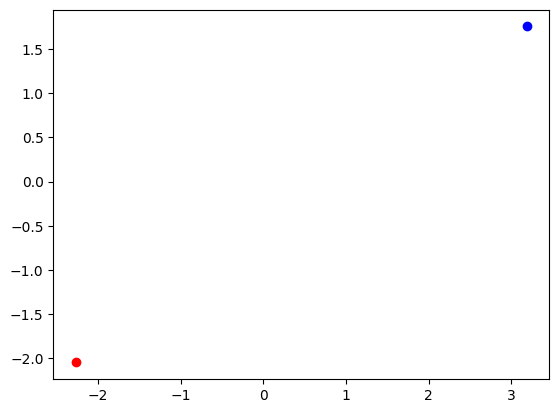

In [64]:
plt.clf()

for i in range(X_s.shape[0]):
    if y_s[i] == -1:
        plt.scatter(X_s[i][0], X_s[i][1], c='b')
    else:
        plt.scatter(X_s[i][0], X_s[i][1], c='r')

plt.show()

由上面的图片可以很清楚的看到算法最终把两千个样本压缩到了只剩两个！

因为我们最开始生成数据的时候两类样本分别以$(-1.5,-1.5)$和$(1.5,1.5)$为中心，并且服从正态分布。

那么显然如果人为划分分界线，应该划分为$x_1 + x_2 = 0$。这个分界线严格符合最小贝叶斯错误率分类。

所以尽管样本被压缩到只有两个，但是按照k-近邻算法进行分类，最终的分界线几乎就是我们画出来的最小贝叶斯错误率分界线。